In [1]:
from scipy.stats import truncnorm, multivariate_normal, norm
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [62]:
# Parameters
mu_1 = 20
mu_2 = 20
sigma_1 = 2
sigma_2 = 2
sigma_t = 0.5
iterations = 100
burn_in = int(0.3 * iterations)

GIBBS SAMPLER

In [63]:
# Helper function to sample from a truncated normal distribution
def truncated_normal(mean, std, lower, upper):
    a, b = (lower - mean) / std, (upper - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

In [64]:
# Gibbs Sampler
def gibbs_sampler(y, iterations=iterations):
    # Initialize t
    if y == 1:
        t = np.abs(np.random.randn())
    else:
        t = -np.abs(np.random.randn())

    
    samples = []
    
    for i in range(iterations):
        # p(s1,s2|t,y)
        # p(S|t,y)
        # QUESTION 3.1
        # Step 1: Draw s_1 and s_2 from the conditional distribution N(mean_s|t, cov_s|t) -
        # (2x2)
        cov_s_t = np.linalg.inv(np.array([[(sigma_1**2 + sigma_t**2) / (sigma_1**2 * sigma_t**2), -1/sigma_t**2],
                                          [-1/sigma_t**2, (sigma_2**2 + sigma_t**2) / (sigma_2**2 * sigma_t**2)]]))
        # (1x2)
        mean_s_t = np.dot(cov_s_t, np.array([mu_1 * sigma_t**2 + t * sigma_1**2 / (sigma_1**2 * sigma_t**2),
                                             mu_2 * sigma_t**2 - t * sigma_2**2 / (sigma_2**2 * sigma_t**2)]))
        
        # Draw from the multivariate normal distribution
        s_1, s_2 = multivariate_normal.rvs(mean=mean_s_t, cov=cov_s_t)

        #DO WE NEED TO UPDATE: mu_1 +mu_2, sigma_1, sigma_2 ??????????????????????????????????????????????????????????????????????????

        #p(t | s_1, s_2, y)
        #p(t | S, y)

        # QUESTION 3.2
        # Step 2: Draw t from the conditional distribution 
        mean_t = s_1 - s_2 

        if y == 1:
            t = truncated_normal(mean_t, sigma_t, 0, np.inf)  # For y = 1, t > 0
        else:
            t = truncated_normal(mean_t, sigma_t, -np.inf, 0)  # For y = -1, t < 0

        # Store samples
        samples.append((s_1, s_2, t))

    return np.array(samples)


In [65]:
# Example execution of the sampler for y = 1
samples = gibbs_sampler(y=1)

# Extract s_1, s_2, and t samples
s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]

print(samples.shape)
print(samples[0])

#s_1_samples, s_2_samples, t_samples 

(100, 3)
[48.53426048 47.88680142  1.02663837]


Trace Plot before Burn-in 

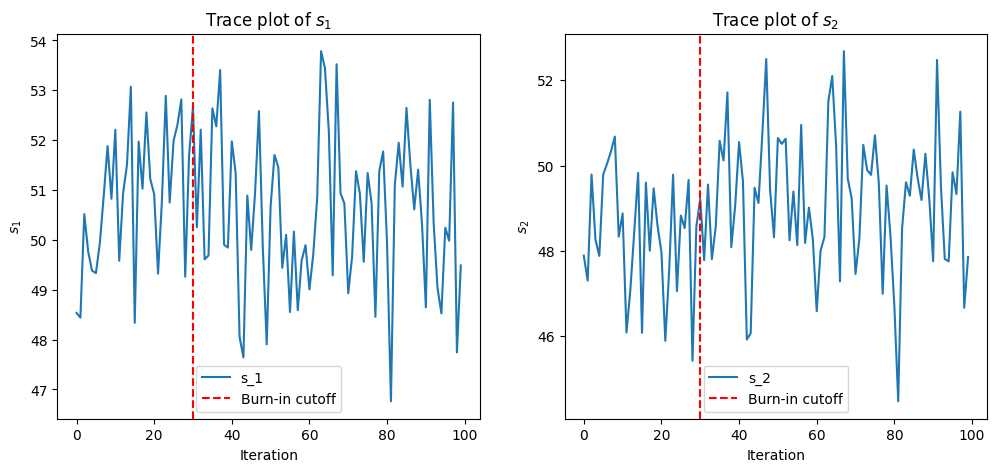

In [66]:
# Trace plots to determine the burn-in period
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(s_1_samples, label="s_1")
plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace plot of $s_1$")
plt.xlabel("Iteration")
plt.ylabel("$s_1$")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(s_2_samples, label="s_2")
plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace plot of $s_2$")
plt.xlabel("Iteration")
plt.ylabel("$s_2$")
plt.legend()
plt.show()

TRACE PLOT AFTER BURN IN

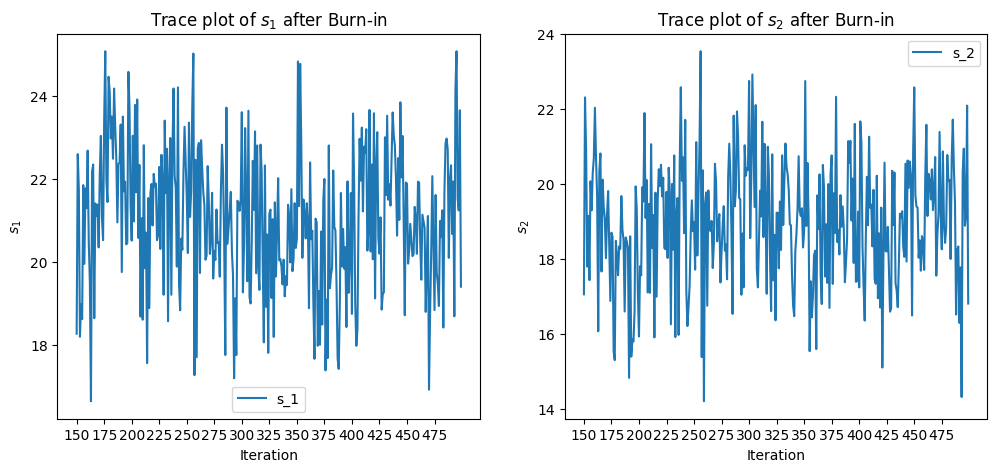

In [57]:
# Trace plots to show iterations after burn-in period
plt.figure(figsize=(12, 5))

# Plot for s_1 after burn-in
plt.subplot(1, 2, 1)
plt.plot(s_1_samples[burn_in:], label="s_1")  # Plotting from burn_in onwards
plt.title("Trace plot of $s_1$ after Burn-in")
plt.xlabel("Iteration")
plt.ylabel("$s_1$")
plt.xticks(ticks=np.arange(0, len(s_1_samples[burn_in:]), step=25), labels=np.arange(burn_in, len(s_1_samples), step=25))  # X-Achse anpassen
plt.legend()

# Plot for s_2 after burn-in
plt.subplot(1, 2, 2)
plt.plot(s_2_samples[burn_in:], label="s_2")  # Plotting from burn_in onwards
plt.title("Trace plot of $s_2$ after Burn-in")
plt.xlabel("Iteration")
plt.ylabel("$s_2$")
plt.xticks(ticks=np.arange(0, len(s_2_samples[burn_in:]), step=25), labels=np.arange(burn_in, len(s_2_samples), step=25))  # X-Achse anpassen
plt.legend()

plt.show()


HISTOGRAM TOGETHER WITH FITTED GAUSSIAN POSTERIOR

In [80]:
# Sample sizes to test
sample_sizes = [iterations * i for i in range(1, 5)]
#sample_sizes = [iterations * i**2 for i in range(1, 5)]

# Placeholder for execution times
execution_times = []


# Create plots
plt.figure(figsize=(15, 12))

for i, size in enumerate(sample_sizes):
    # Start timing
    start_time = time.time()
    
    # Generate samples after burn-in period
    samples = gibbs_sampler(y=1, iterations=size)
    s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]
    
    # Remove samples from the burn-in period (assuming burn_in = 20)
    #s_1_samples_after_burn_in = s_1_samples[burn_in:]
    #s_2_samples_after_burn_in = s_2_samples[burn_in:]
    
    sample_posterior_mean = [np.mean(s_1_samples[burn_in:]), np.mean(s_2_samples[burn_in:])]

    # Stack samples together after burn-in
    samples_after_burn_in = np.vstack((s_1_samples[burn_in:], s_2_samples[burn_in:]))

    # Calculate the covariance matrix
    sample_posterior_cov = np.cov(samples_after_burn_in)

    gaussian_dist = multivariate_normal(mean=sample_posterior_mean, cov=sample_posterior_cov)

    #sample_posterior_cov = [np.cov(s_1_samples[burn_in:]), np.cov(s_2_samples[burn_in:])]


    print(gaussian_dist)

pdf_value = gaussian_dist.pdf(samples_after_burn_in.T)
print(pdf_value)

#     # Create Joint Plot
#     plt.subplot(2, 2, i + 1)
    
#     # Main plot with joint distribution
#     sns.kdeplot(x=s_1_samples_after_burn_in, y=s_2_samples_after_burn_in, fill=True, cmap='Blues', thresh=0, levels=20)
    
#     # Top: Histogram for s1
#     ax_inset_top = plt.gca().inset_axes([0.1, 0.9, 0.8, 0.2])  # Top
#     sns.histplot(s_1_samples_after_burn_in, bins=50, color='g', kde=True, stat="density", ax=ax_inset_top)
#     ax_inset_top.set_xlabel('$s_1$')

#     # Right: Create a new inset for the rotated s2 histogram
#     ax_inset_right = plt.gca().inset_axes([0.9, 0.1, 0.2, 0.8])  # Right
    
#     # Set the orientation of the histogram to horizontal to match the 90-degree rotation
#     sns.histplot(s_2_samples_after_burn_in, bins=50, color='b', kde=True, stat="density", ax=ax_inset_right, orientation='horizontal')
    
#     # Rotate the entire axis layout manually using a transformation
#     ax_inset_right.set_aspect('auto')
#     ax_inset_right.yaxis.tick_right()
#     ax_inset_right.yaxis.set_label_position("right")
    
#     # Rotate axis and labels properly to reflect the 90-degree rotation
#     ax_inset_right.set_xlabel('Density')
#     ax_inset_right.set_ylabel('$s_2$', labelpad=10)

#     # Reverse the limits to make the peak of the histogram on the left
#     ax_inset_right.set_xlim(ax_inset_right.get_xlim()[::-1])

#     plt.title(f'Joint Distribution (Sample Size: {size})')
#     plt.xlabel('$s_1$')
#     plt.ylabel('$s_2$')

#     # Report time taken for sampling
#     execution_time = time.time() - start_time
#     execution_times.append(execution_time)

# plt.tight_layout()
# plt.show()

# Print execution times
for size, exec_time in zip(sample_sizes, execution_times):
    print(f'Time to draw {size} samples: {exec_time:.2f} seconds')



[5.84630150e-02 6.26864933e-02 1.46152520e-02 5.49221137e-02
 4.50429323e-02 2.54362305e-02 3.20057352e-02 5.82400773e-02
 2.93257074e-02 3.35322127e-02 2.78810089e-02 2.58798181e-02
 5.30124616e-02 5.34610543e-02 4.00640066e-02 4.17904063e-02
 1.04559070e-02 5.09676751e-02 3.61308940e-02 3.86015639e-02
 2.11821991e-02 9.58067024e-03 7.72911338e-03 3.10572338e-02
 3.41436792e-02 6.50463790e-02 2.11553624e-02 2.85207752e-02
 5.32187085e-02 2.38391124e-02 2.72781099e-02 4.87510912e-02
 6.38639171e-02 5.37856370e-02 5.40241053e-02 2.79034168e-02
 3.29945118e-02 2.84958980e-02 1.28303547e-03 2.26989545e-02
 4.61377539e-02 4.18251701e-02 5.03628654e-02 5.27067052e-02
 5.17436738e-02 3.82786114e-02 3.40980523e-02 4.19133657e-02
 3.95164904e-02 8.29192706e-03 7.05113520e-03 4.43559187e-03
 1.77283277e-02 5.31779851e-02 4.76612471e-02 2.61399375e-02
 2.32335223e-02 6.22010587e-02 6.50049691e-02 2.36021445e-02
 2.76642407e-02 3.95907894e-02 3.77755751e-02 2.98327870e-02
 3.07702459e-02 2.611028

<Figure size 1500x1200 with 0 Axes>